In [13]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lb
from scipy.fftpack import fft
import sounddevice as sd
from scipy.signal import hann, hamming, freqz

# from audiolazy import lazy_lpc as lpc
import librosa 

In [2]:
# provided functions
def est_predictor_gain(x, a, p):
    '''
    A function to compute gain of the residual signal in LP analysis.
    x:  signal 
    a: LPC coefficients
    p: order of the filter
    '''
    cor = np.correlate(x, x, mode='full')
    
    rr = cor[len(cor)//2: len(cor)//2+p+1]
    g = np.sqrt(np.sum(a*rr))
    return g

   
    
def reject_outliers(data, m=2):
    '''
    Function to reject outliers. All values beyond m standard deviations from mean are excluded
    '''
    return data[abs(data - np.mean(data)) < m * np.std(data)]

### 1. Linear prediction analysis. (1 point) 

C:\Users\Phan Phuong Uyen\AppData\Local\Temp\ipykernel_20756\3248924489.py:11: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  win = hamming(wLen) # hamming window for example


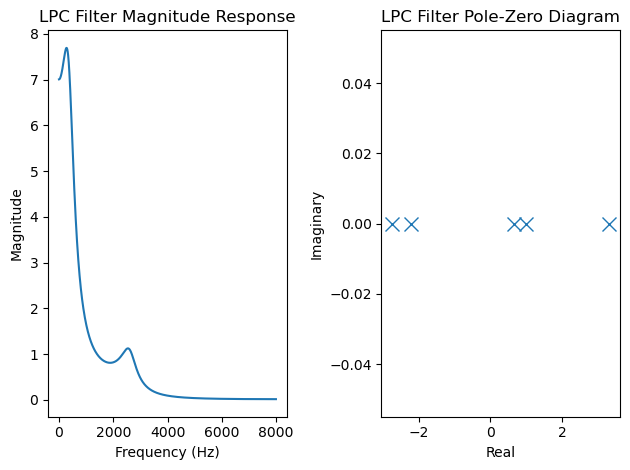

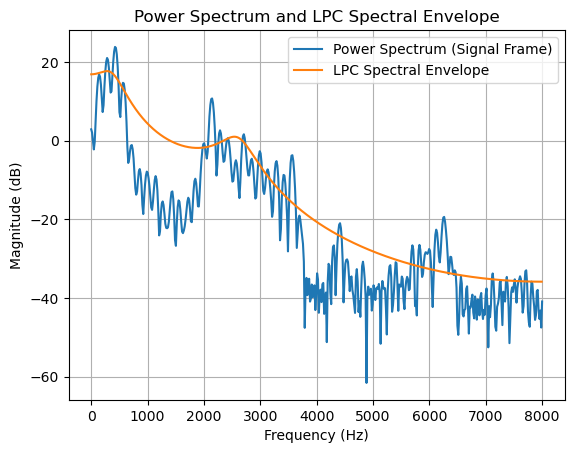

In [4]:
# Read audio
audioIn, fs = lb.load('e.wav', sr=None)   
# filter order
p = 4  # d) has to be tuned

# number of DFT points
nfft = 1024

inInd =0
wLen = int(0.02*fs) # 20 ms window
win = hamming(wLen) # hamming window for example

cnt = 0
numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
formants  = []                                     # A placeholder for storing formants

# choose a representative frame of the vowel
plot_frame = int(numframes/2)  # middle of the vowel

# The analysis loop
while inInd< len(audioIn)-wLen:
    # audio frame
    frame = audioIn[inInd:inInd+wLen]* win
    
    
    # a) compute LPC and gain using audiolazy library
    lpc_coeffs = librosa.lpc(frame, order=p)
    gain = est_predictor_gain(frame, lpc_coeffs, p)

    
    # b) Compute the filter transfer function using scipy.signal.freqz
    frequencies, h = freqz(gain, lpc_coeffs, worN=nfft, fs=fs) 
    
    # Compute DFT spectrum
    spectrum = np.fft.fft(frame, nfft)
    
    # Plot the magnitude response of the LPC filter for the middle frame
    if cnt == plot_frame:
        plt.figure()

        # Plot the LPC filter magnitude response
        plt.subplot(1, 2, 1)
        plt.plot(frequencies, np.abs(h))
        plt.title('LPC Filter Magnitude Response')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')

        # Plot the LPC filter pole-zero diagram
        plt.subplot(1, 2, 2)
        plt.plot(np.real(lpc_coeffs), np.imag(lpc_coeffs), 'x', markersize=10)
        plt.title('LPC Filter Pole-Zero Diagram')
        plt.xlabel('Real')
        plt.ylabel('Imaginary')

        plt.tight_layout()
        plt.show()
        
    # c) Select a frame and plot the FFT spectrum and LPC spectrum in the same figure
    if cnt == plot_frame :
        # plot DFT spectrum (remember both in dB scale)
        # plot LPC spectrum
        plt.figure()

        # Plot the power spectrum of the signal frame in dB scale
        spectrum = 20 * np.log10(np.abs(spectrum))
        plt.plot(np.linspace(0, fs//2, nfft//2), spectrum[:nfft//2], label='Power Spectrum (Signal Frame)')

        # Plot the filter transfer function (LPC spectral envelope) in dB scale
        lpc_envelope = 20 * np.log10(np.abs(h))
        plt.plot(frequencies, lpc_envelope, label='LPC Spectral Envelope')

        plt.title('Power Spectrum and LPC Spectral Envelope')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude (dB)')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    inInd = inInd + int(wLen/2) # frame advance
    
    cnt = cnt+1
    


#### d) Comment of the connection between lpc model order and peaks in the DFT spectrum.

In [5]:
# The LPC model is used to approximate the spectral envelope of a signal, 
# and its order determines how many coefficients are used in this approximation.
# The higher the lpc model order, the finer the detail it captures in the spectral envelope. 

C:\Users\Phan Phuong Uyen\AppData\Local\Temp\ipykernel_20756\726943795.py:7: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  win = hamming(wLen) # hamming window for example


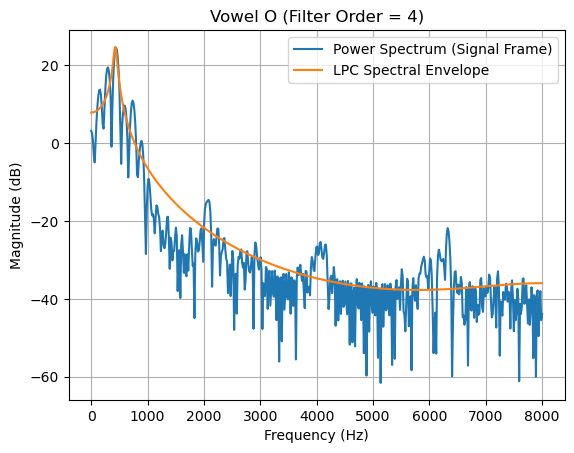

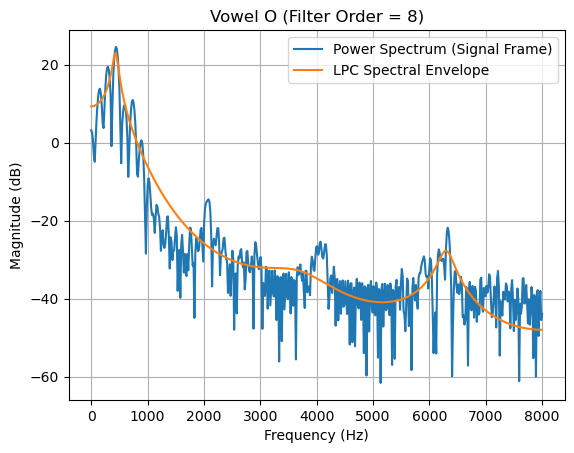

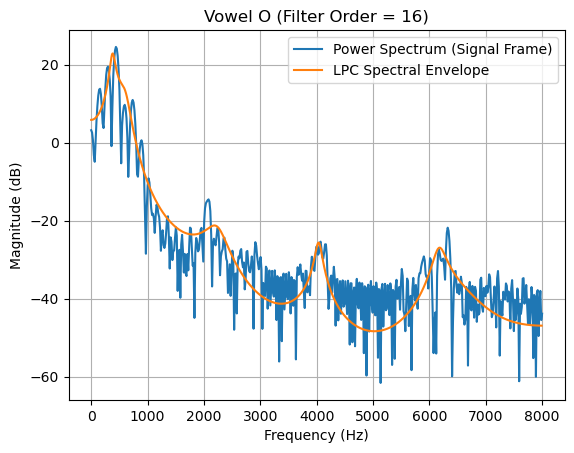

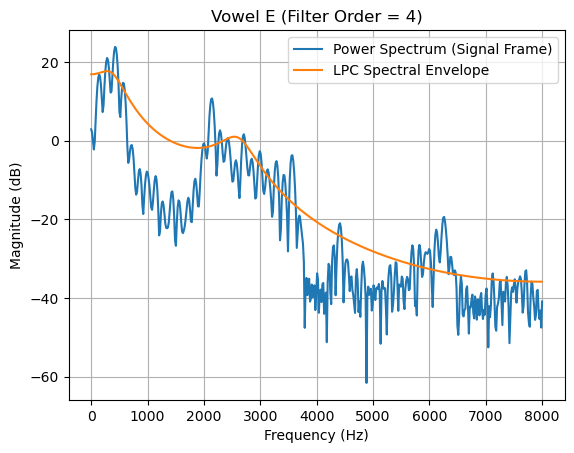

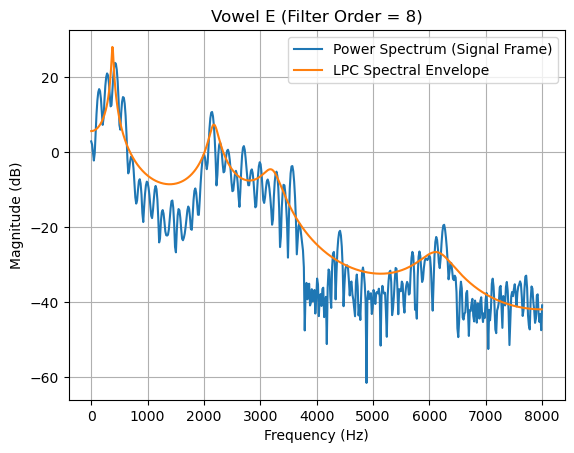

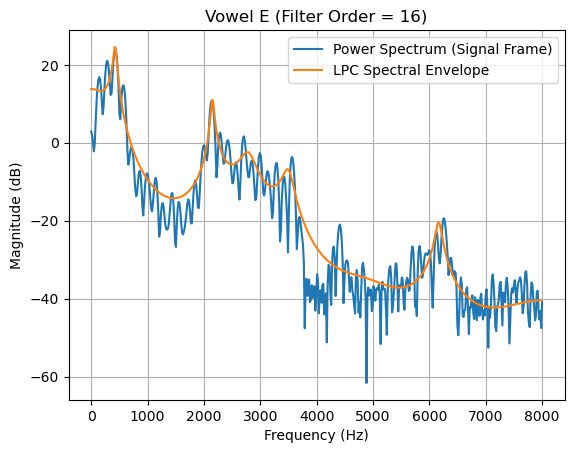

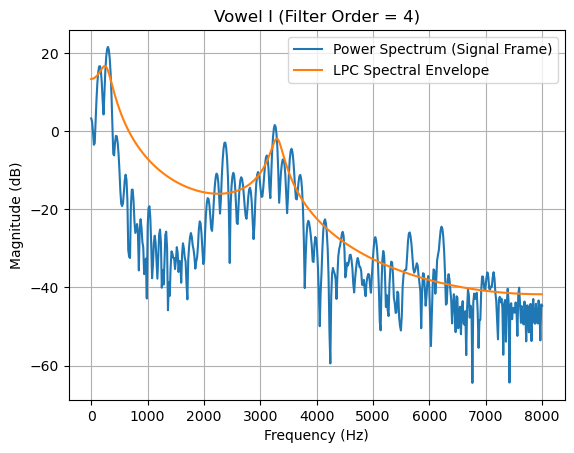

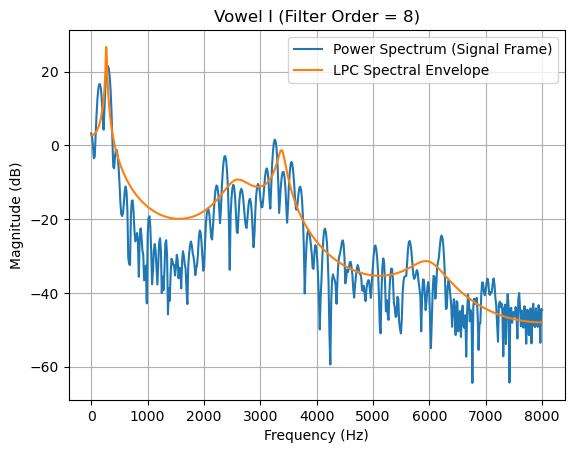

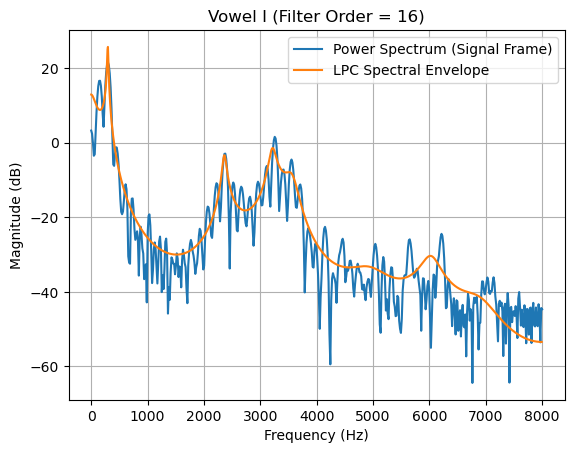

In [6]:
def analyze_vowel(audioIn, fs, vowel_name, wLen=0.02, overlap=0.5, filter_orders=[4, 8, 16]):

    for p in filter_orders:
        nfft = 1024
        inInd =0
        wLen = int(0.02*fs) # 20 ms window
        win = hamming(wLen) # hamming window for example

        cnt = 0
        numframes = np.ceil( (len(audioIn)-wLen)/(wLen/2)) # number of franes 
        formants  = []                                     # A placeholder for storing formants

        # choose a representative frame of the vowel
        plot_frame = int(numframes/2)  # middle of the vowel

        # The analysis loop
        while inInd< len(audioIn)-wLen:
            # audio frame
            frame = audioIn[inInd:inInd+wLen]* win


            # a) compute LPC and gain using audiolazy library
            lpc_coeffs = librosa.lpc(frame, order=p)
            gain = est_predictor_gain(frame, lpc_coeffs, p)


            # b) Compute the filter transfer function using scipy.signal.freqz
            frequencies, h = freqz(gain, lpc_coeffs, worN=nfft, fs=fs) 

            # Compute DFT spectrum
            spectrum = np.fft.fft(frame, nfft)

            

            # c) Select a frame and plot the FFT spectrum and LPC spectrum in the same figure
            if cnt == plot_frame :
                # plot DFT spectrum (remember both in dB scale)
                # plot LPC spectrum
                plt.figure()

                # Plot the power spectrum of the signal frame in dB scale
                spectrum = 20 * np.log10(np.abs(spectrum))
                plt.plot(np.linspace(0, fs//2, nfft//2), spectrum[:nfft//2], label='Power Spectrum (Signal Frame)')

                # Plot the filter transfer function (LPC spectral envelope) in dB scale
                lpc_envelope = 20 * np.log10(np.abs(h))
                plt.plot(frequencies, lpc_envelope, label='LPC Spectral Envelope')

                plt.title(f'{vowel_name} (Filter Order = {p})')
                plt.xlabel('Frequency (Hz)')
                plt.ylabel('Magnitude (dB)')
                plt.legend()
                plt.grid(True)
                plt.show()
                
            inInd = inInd + int(wLen/2) # frame advance
            cnt = cnt+1

# Read audio for different vowels
vowel_o, fso = lb.load('o.wav', sr=None)
vowel_e, fse = lb.load('e.wav', sr=None)
vowel_i, fsi = lb.load('i.wav', sr=None)

# Analyze each vowel
analyze_vowel(vowel_o, fso, 'Vowel O')
analyze_vowel(vowel_e, fse, 'Vowel E')
analyze_vowel(vowel_i, fsi, 'Vowel I')

#### Is the best order selection dependent on the vowel or not?

In [ ]:
# The choice of order is not dependent on the vowel 
# It can be seen from the plot above that order 16 does the best job for different vowels 
# and order 4 does poorly, for 3 vowels 

### 2. Formant analysis. (1 point)

#### Add more steps in the previous analysis loop

C:\Users\Phan Phuong Uyen\AppData\Local\Temp\ipykernel_20756\2530955989.py:7: DeprecationWarning: Importing hamming from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hamming' or the convenience function 'scipy.signal.get_window' instead.
  win = hamming(wLen)  # hamming window for example


------ The computed formants for Vowel E are: [ 386.29380475 1924.98489026 2682.39697213]


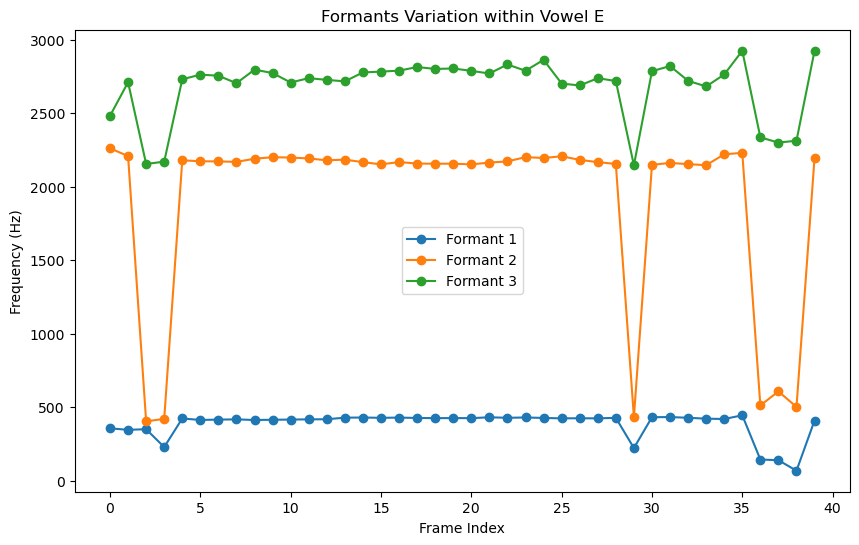

------ The computed formants for Vowel I are: [ 311.94830659 2270.81368136 3229.74371613]


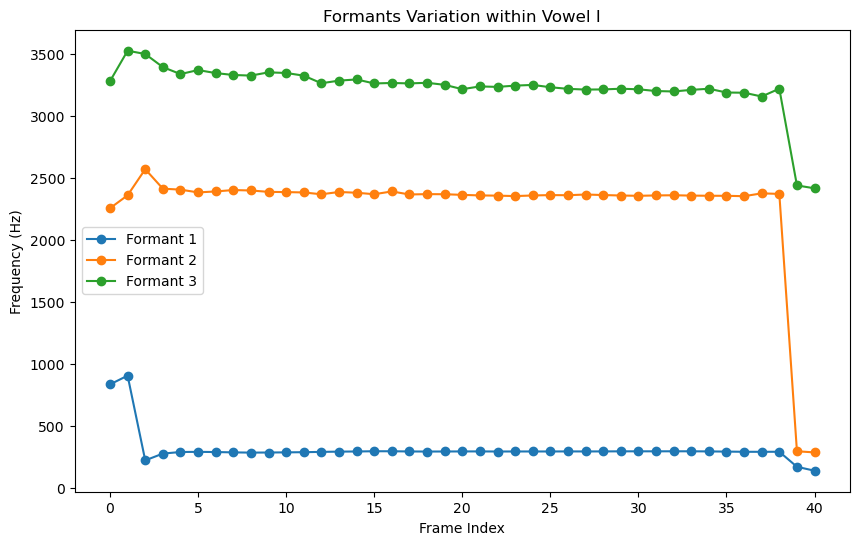

------ The computed formants for Vowel O are: [ 425.14459322  815.93138007 2180.98230478]


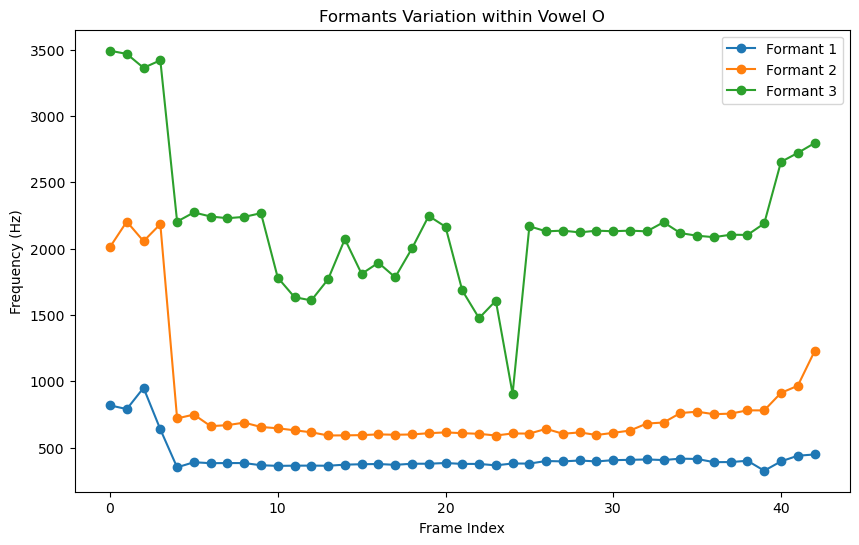

In [19]:
def analyze_formant(audioIn, fs, vowel_name, wLen=0.02, overlap=0.5, p=16):
    # number of DFT points
    nfft = 1024

    inInd = 0
    wLen = int(0.02 * fs)  # 20 ms window
    win = hamming(wLen)  # hamming window for example

    cnt = 0
    numframes = np.ceil((len(audioIn) - wLen) / (wLen / 2))  # number of frames
    formants = []  # A placeholder for storing formants

    # choose a representative frame of the vowel
    plot_frame = int(numframes / 2)  # middle of the vowel

    # The analysis loop
    while inInd < len(audioIn) - wLen:
        # audio frame
        frame = audioIn[inInd:inInd + wLen] * win

        # Compute LPC and gain using audiolazy library
        lpc_coeffs = librosa.lpc(frame, order=p)
        gain = est_predictor_gain(frame, lpc_coeffs, p)

        # Compute the filter transfer function using scipy.signal.freqz
        frequencies, h = freqz(gain, lpc_coeffs, worN=nfft, fs=fs)

        # Compute DFT spectrum
        spectrum = np.fft.fft(frame, nfft)

        # a) Compute roots (np.roots)
        roots = np.roots(lpc_coeffs)

        # LPC coefficients are real-valued, the roots occur in complex conjugate pairs.
        # Retain only the roots with +ve sign for the imaginary part
        roots = roots[roots.imag > 0]

        # b.1) compute formants from roots (np.angle)
        angz = np.angle(roots)

        # convert to Hertz from angular frequencies
        angz = angz * (fs / (2 * np.pi))

        # sort the formants in increasing order
        angz = np.sort(angz)

        # remove zero frequencies
        angz = angz[angz != 0]

        # b.2) Save first three formants
        formants.append(angz[:3])

        inInd = inInd + int(wLen / 2)  # frame advance
        cnt = cnt + 1

    formants = np.array(formants)
    # b.3) For each separate vowel calculate average formant frequencies
    avg_formants = np.mean(formants, axis=0)
    print(f'------ The computed formants for {vowel_name} are: {avg_formants}')

    # Plot formants within a vowel
    plt.figure(figsize=(10, 6))
    plt.plot(formants[:, 0], label='Formant 1', marker='o')
    plt.plot(formants[:, 1], label='Formant 2', marker='o')
    plt.plot(formants[:, 2], label='Formant 3', marker='o')
    plt.title(f'Formants Variation within {vowel_name}')
    plt.xlabel('Frame Index')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.show()
    # Refine formant estimations (optional)

# Read audio for different vowels
audio_1, fs1 = lb.load('e.wav', sr=None)
analyze_formant(audio_1, fs1, 'Vowel E')

audio_2, fs2 = lb.load('i.wav', sr=None)
analyze_formant(audio_2, fs2, 'Vowel I')

audio_3, fs3 = lb.load('o.wav', sr=None)
analyze_formant(audio_3, fs3, 'Vowel O')

#### b.4) Compare the obtained values with the indicative values. 

In [65]:
### Obtained value 
# ------ The computed formants for Vowel O are: [ 425.14459322  815.93138007 2180.98230478]
# ------ The computed formants for Vowel E are: [ 386.29380475 1924.98489026 2682.39697213]
# ------ The computed formants for Vowel I are: [ 311.94830659 2270.81368136 3229.74371613]

### Indicative value 
# ------ The computed formants for Vowel O are: [ 406 727 2090]
# ------ The computed formants for Vowel E are: [ 434 2148 2763]
# ------ The computed formants for Vowel I are: [ 294 2343 3251]

# Observations:

# For Vowel O, the first and second formants are close, but the third formant shows a larger deviation.
# For Vowel E, the second formant is reasonably close, but the first and third formants deviate more.
# For Vowel I, the second and third formants are relatively close, but the first formant shows a larger deviation.
# Overall, there are differences between the obtained and indicative formant values, which could be 
# influenced by the model order. 

### Bonus problem: What happens if you apply LPC to the oboe sound? What are the corresponding "formants"?